In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
from sklearn.utils import class_weight




In [29]:
# ============ CONFIGURACIÓN ============
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
DATA_DIR = "flores"

# ============ DATA AUGMENTATION (aplicado al dataset) ============
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.15, 0.15),
    layers.RandomBrightness(0.2),
])

def augment(image, label):
    return data_augmentation(image, training=True), label

In [30]:

# ============ CARGAR DATOS ============
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR + '/train',
    labels='inferred',
    label_mode='int',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR + '/val',
    labels='inferred',
    label_mode='int',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR + '/test',
    labels='inferred',
    label_mode='int',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Clases:", class_names)

# ============ CALCULAR PESOS DE CLASE ============
train_labels = []
for _, labels in train_ds:
    train_labels.extend(labels.numpy())
train_labels = np.array(train_labels)

class_weights_array = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = {i: weight for i, weight in enumerate(class_weights_array)}



Found 3017 files belonging to 5 classes.
Found 865 files belonging to 5 classes.
Found 435 files belonging to 5 classes.
Clases: ['diente_de_leon', 'girasol', 'margarita', 'rosa', 'tulipan']


In [31]:

# ============ APLICAR AUGMENTATION Y OPTIMIZACIÓN ============
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# ============ MODELO (SIN data augmentation integrado) ============
def build_model(input_shape=(224,224,3), num_classes=5):
    inputs = layers.Input(shape=input_shape)
    
    # Normalización
    x = layers.Rescaling(1./127.5, offset=-1)(inputs)
    
    # Modelo preentrenado
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False
    
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model, base_model

In [32]:

# Crear modelo
model, base_model = build_model(input_shape=(224,224,3), num_classes=num_classes)

# ============ COMPILAR ============
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
# ============ ENTRENAR FASE 1 ============
print("\n=== ENTRENANDO FASE 1 (Transfer Learning) ===")

checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-7, verbose=1)

history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[checkpoint, early_stop, reduce_lr],
    class_weight=class_weights
)

In [ ]:

# ============ FINE-TUNING FASE 2 ============
print("\n=== ENTRENANDO FASE 2 (Fine-Tuning) ===")
base_model.trainable = True

# Congelar las primeras capas
for layer in base_model.layers[:-30]:
    layer.trainable = False

print(f"Capas entrenables: {sum([1 for layer in base_model.layers if layer.trainable])}")

# Recompilar con learning rate más bajo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

checkpoint2 = ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stop2 = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr2 = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-7, verbose=1)

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[checkpoint2, early_stop2, reduce_lr2],
    class_weight=class_weights
)

Epoch 1/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 731ms/step - accuracy: 0.3664 - loss: 1.5720

95/95 ━━━━━━━━━━━━━━━━━━━━ 80s 808ms/step - accuracy: 0.4173 - loss: 1.4317 - val_accuracy: 0.2439 - val_loss: 1.7000 - learning_rate: 0.0010
Epoch 2/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 861ms/step - accuracy: 0.5005 - loss: 1.2397 - val_accuracy: 0.2439 - val_loss: 2.2225 - learning_rate: 0.0010
Epoch 3/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 91s 957ms/step - accuracy: 0.5406 - loss: 1.1541 - val_accuracy: 0.2486 - val_loss: 2.5073 - learning_rate: 0.0010
Epoch 4/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 87s 919ms/step - accuracy: 0.5509 - loss: 1.1018 - val_accuracy: 0.2705 - val_loss: 2.5411 - learning_rate: 0.0010
Epoch 5/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 87s 921ms/step - accuracy: 0.5900 - loss: 1.0493 - val_accuracy: 0.2925 - val_loss: 2.3302 - learning_rate: 5.0000e-04
Epoch 6/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 87s 915ms/step - accuracy: 0.6046 - loss: 0.9896 - val_accuracy: 0.3618 - val_loss: 1.8106 - learning_rate: 5.0000e-04
Epoch 7/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 883ms/step - accuracy: 0.6182 - loss: 1.0037

95/95 ━━━━━━━━━━━━━━━━━━━━ 88s 930ms/step - accuracy: 0.6255 - loss: 0.9653 - val_accuracy: 0.5723 - val_loss: 1.0877 - learning_rate: 5.0000e-04
Epoch 8/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 873ms/step - accuracy: 0.6157 - loss: 0.9774

95/95 ━━━━━━━━━━━━━━━━━━━━ 88s 924ms/step - accuracy: 0.6291 - loss: 0.9532 - val_accuracy: 0.6000 - val_loss: 1.0383 - learning_rate: 5.0000e-04
Epoch 9/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.6318 - loss: 0.9441

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 873ms/step - accuracy: 0.6377 - loss: 0.9284 - val_accuracy: 0.6543 - val_loss: 0.9025 - learning_rate: 5.0000e-04
Epoch 10/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 87s 917ms/step - accuracy: 0.6520 - loss: 0.9274 - val_accuracy: 0.6277 - val_loss: 0.9300 - learning_rate: 5.0000e-04
Epoch 11/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 89s 938ms/step - accuracy: 0.6553 - loss: 0.8909 - val_accuracy: 0.5387 - val_loss: 1.1407 - learning_rate: 5.0000e-04
Epoch 12/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 87s 920ms/step - accuracy: 0.6546 - loss: 0.8820 - val_accuracy: 0.6081 - val_loss: 1.0532 - learning_rate: 5.0000e-04
Epoch 13/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 87s 919ms/step - accuracy: 0.6782 - loss: 0.8506 - val_accuracy: 0.6451 - val_loss: 0.9028 - learning_rate: 2.5000e-04
Epoch 14/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 865ms/step - accuracy: 0.6718 - loss: 0.8612

95/95 ━━━━━━━━━━━━━━━━━━━━ 87s 914ms/step - accuracy: 0.6831 - loss: 0.8367 - val_accuracy: 0.6867 - val_loss: 0.8358 - learning_rate: 2.5000e-04
Epoch 15/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 88s 923ms/step - accuracy: 0.6725 - loss: 0.8193 - val_accuracy: 0.6751 - val_loss: 0.8436 - learning_rate: 2.5000e-04
Epoch 16/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 95s 994ms/step - accuracy: 0.6894 - loss: 0.8269 - val_accuracy: 0.6520 - val_loss: 0.9203 - learning_rate: 2.5000e-04
Epoch 17/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 95s 995ms/step - accuracy: 0.6891 - loss: 0.8251 - val_accuracy: 0.6821 - val_loss: 0.8434 - learning_rate: 2.5000e-04
Epoch 18/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 962ms/step - accuracy: 0.6854 - loss: 0.8117

95/95 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.7027 - loss: 0.7976 - val_accuracy: 0.6971 - val_loss: 0.8307 - learning_rate: 1.2500e-04
Epoch 19/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 942ms/step - accuracy: 0.6951 - loss: 0.7981

95/95 ━━━━━━━━━━━━━━━━━━━━ 95s 995ms/step - accuracy: 0.7057 - loss: 0.7782 - val_accuracy: 0.6902 - val_loss: 0.8298 - learning_rate: 1.2500e-04
Epoch 20/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.6884 - loss: 0.8033

95/95 ━━━━━━━━━━━━━━━━━━━━ 93s 976ms/step - accuracy: 0.6997 - loss: 0.7837 - val_accuracy: 0.6936 - val_loss: 0.8201 - learning_rate: 1.2500e-04
Epoch 21/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 89s 940ms/step - accuracy: 0.7100 - loss: 0.7723 - val_accuracy: 0.6798 - val_loss: 0.8493 - learning_rate: 1.2500e-04
Epoch 22/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7073 - loss: 0.7762

95/95 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.7103 - loss: 0.7770 - val_accuracy: 0.7052 - val_loss: 0.7989 - learning_rate: 1.2500e-04
Epoch 23/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.7179 - loss: 0.7504 - val_accuracy: 0.6983 - val_loss: 0.8161 - learning_rate: 1.2500e-04
Epoch 24/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 91s 958ms/step - accuracy: 0.7156 - loss: 0.7374 - val_accuracy: 0.6705 - val_loss: 0.8602 - learning_rate: 1.2500e-04
Epoch 25/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 88s 932ms/step - accuracy: 0.7169 - loss: 0.7369 - val_accuracy: 0.6832 - val_loss: 0.8615 - learning_rate: 1.2500e-04
Epoch 26/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.7206 - loss: 0.7456 - val_accuracy: 0.6879 - val_loss: 0.8360 - learning_rate: 6.2500e-05
Epoch 27/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.7216 - loss: 0.7298 - val_accuracy: 0.6902 - val_loss: 0.8462 - learning_rate: 6.2500e-05
Epoch 28/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 89s 932ms/step - accuracy: 0.7193

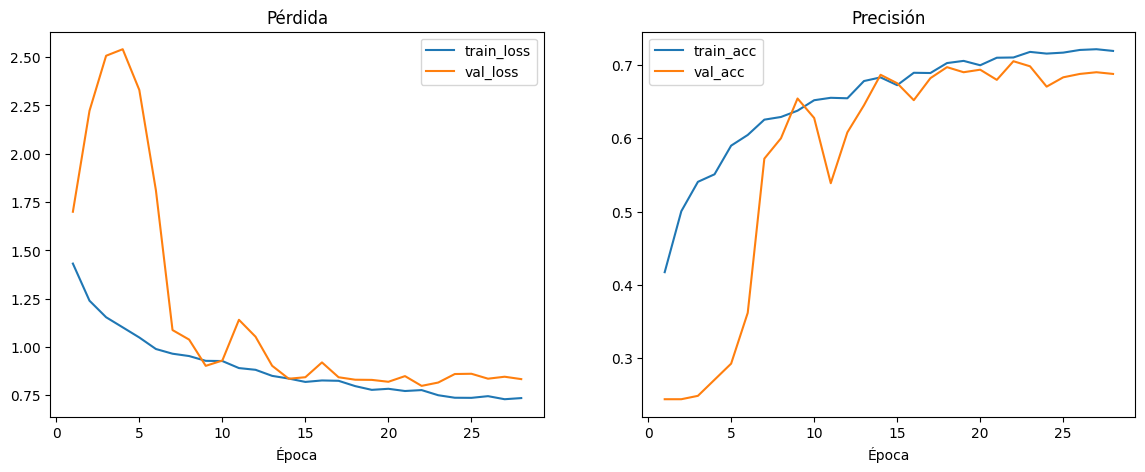

In [ ]:
# ============ GUARDAR MODELO ============
model.save("flower_model_final.h5")
print("\n✓ Modelo guardado: flower_model_final.h5")

In [ ]:

# ============ GRÁFICAS ============
# Combinar historiales
for key in history1.history.keys():
    history1.history[key].extend(history2.history[key])

hist = history1.history
epochs = range(1, len(hist['loss'])+1)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(epochs, hist['loss'], label='train_loss')
plt.plot(epochs, hist['val_loss'], label='val_loss')
plt.title('Pérdida')
plt.xlabel('Época')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, hist['accuracy'], label='train_acc')
plt.plot(epochs, hist['val_accuracy'], label='val_acc')
plt.title('Precisión')
plt.xlabel('Época')
plt.legend()
plt.tight_layout()
plt.show()

# ============ EVALUACIÓN ============
print("\n=== EVALUACIÓN TEST SET ===")
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.6828 - loss: 0.7918
Test loss: 0.7918, Test accuracy: 0.6828


In [ ]:


# ============ MATRIZ DE CONFUSIÓN ============
y_true = []
y_pred = []
for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Matriz de Confusión')
plt.colorbar()
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center',
                color='white' if cm[i, j] > cm.max()/2 else 'black')
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Classification report:
                 precision    recall  f1-score   support

diente_de_leon       0.75      0.72      0.73       106
       girasol       0.63      0.86      0.73        74
     margarita       0.70      0.68      0.69        77
          rosa       0.61      0.46      0.52        79
       tulipan       0.69      0.70      0.69        99

      accuracy                           0.68       435
     macro avg       0.68      0.68 

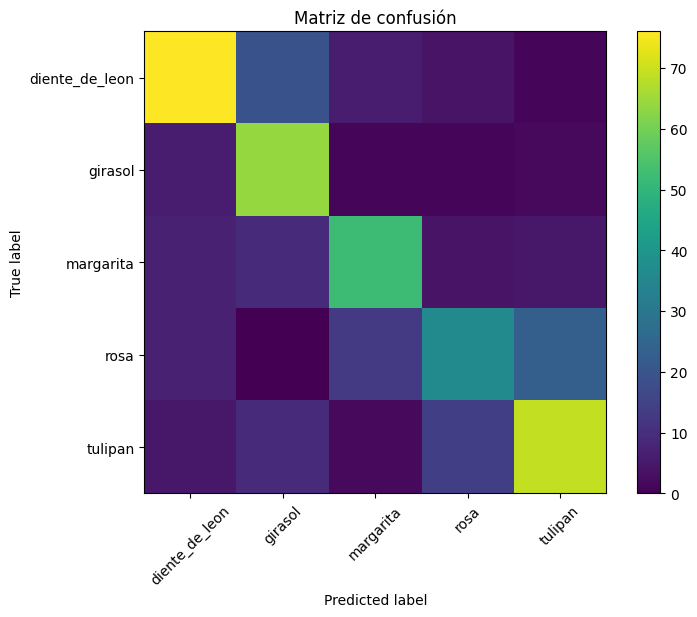

In [ ]:

# ============ FUNCIÓN DE PREDICCIÓN ============
def predict_image(model, img_path, class_names, image_size=(224,224)):
    img = image.load_img(img_path, target_size=image_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    preds = model.predict(x, verbose=0)[0]
    top_idx = np.argmax(preds)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Predicción: {class_names[top_idx]}\nConfianza: {preds[top_idx]:.2%}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    sorted_idx = np.argsort(preds)[::-1]
    colors = ['green' if i == top_idx else 'skyblue' for i in sorted_idx]
    plt.barh([class_names[i] for i in sorted_idx], [preds[i] for i in sorted_idx], color=colors)
    plt.xlabel('Probabilidad')
    plt.title('Probabilidades')
    plt.xlim([0, 1])
    plt.tight_layout()
    plt.show()
    
    return top_idx, preds[top_idx], preds

# ============ CARGAR Y PROBAR ============
print("\n=== CARGANDO MODELO ===")
inference_model = tf.keras.models.load_model("flower_model_final.h5")

print("\n=== PREDICCIÓN ===")
idx, prob, all_probs = predict_image(inference_model, "probar.jpg", class_names)

print(f"\nClase predicha: {class_names[idx]}")
print(f"Confianza: {prob:.2%}")
print("\nTodas las probabilidades:")
for cls, p in zip(class_names, all_probs):
    print(f"  {cls}: {p:.2%}")

In [14]:
# ##### Evaluación final en test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

#Matriz de confusión y reporte por clase

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.6828 - loss: 0.7918
Test loss: 0.7918, Test accuracy: 0.6828


In [15]:

# Obtener etiquetas verdaderas y predichas
y_true = []
y_pred = []
for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
print("Classification report:\n", classification_report(y_true, y_pred, target_names=class_names))
print("Confusion matrix:\n", cm)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Classification report:
                 precision    recall  f1-score   support

diente_de_leon       0.75      0.72      0.73       106
       girasol       0.63      0.86      0.73        74
     margarita       0.70      0.68      0.69        77
          rosa       0.61      0.46      0.52        79
       tulipan       0.69      0.70      0.69        99

      accuracy                           0.68       435
     macro avg       0.68      0.68  

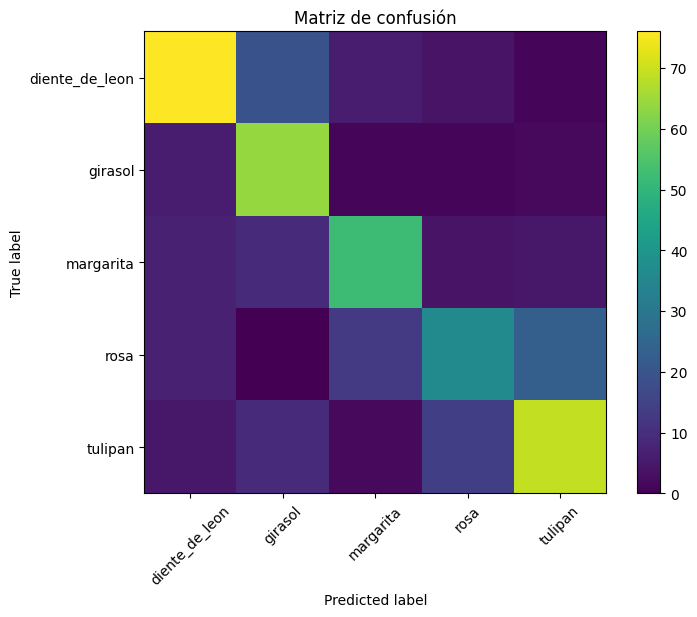

In [16]:
# Mostrar matriz como imagen
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest')
plt.title('Matriz de confusión')
plt.colorbar()
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [26]:
def predict_image(model, img_path, class_names, image_size=(128,128)):
    img = image.load_img(img_path, target_size=image_size)
    x = image.img_to_array(img)
    x = x.astype('float32') / 255.0
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)[0]
    top_idx = np.argmax(preds)
    return top_idx, preds[top_idx], preds

# Uso:
idx, prob, all_probs = predict_image(model, "3625257860_33efeef614_m.jpg", class_names)
print(class_names[idx], prob)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
diente_de_leon 0.8240489
